<a href="https://colab.research.google.com/github/ARBasharat/AudioClassification/blob/master/AudioClassification2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Contact: abbash@iu.edu <br/>
Audio Spectrogram Classification using 2D-Convolution <br/>

# Import Libraries

In [1]:
import random
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import librosa
from scipy import signal

#Read Data from Google Drive

In [2]:
from google.colab import drive
drive.mount("/content/drive")

train = np.load("drive/My Drive/AudioClassification/audio_train.npy").astype('float32')
test = np.load("drive/My Drive/AudioClassification/audio_test.npy").astype('float32')
train_labels_df = pd.read_csv("drive/My Drive/AudioClassification/labels_train.csv")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Process the data

In [3]:
train_labels = train_labels_df.to_numpy()[:,1]
labels_categorical = keras.utils.to_categorical(train_labels)

X_train_original, X_val_original, y_train_original, y_val = train_test_split(train, 
                          labels_categorical, test_size=0.20, random_state=42)

print("Training Data:", X_train_original.shape)
print("Training Labels:", y_train_original.shape)
print("Validation Data:", X_val_original.shape)
print("Validation Labels:", y_val.shape)
print("Testing Data:", test.shape)

Training Data: (753, 30000)
Training Labels: (753, 10)
Validation Data: (189, 30000)
Validation Labels: (189, 10)
Testing Data: (558, 30000)


In [4]:
## We switch between white and normal noise randomly

def add_white_noise(data, rate = 0.05):
  data_with_white_noise = data + rate * np.random.randn(len(data))
  return data_with_white_noise

'''
Noise addition using normal distribution with mean = 0 and std =1
Permissible noise factor value = x > 0.004
'''
def add_normal_distributed_noise(data, rate = 0.09, sr = 30000):
  data_with_noramlized_noise = data + rate * np.random.normal(0, 1, len(data))
  return data_with_noramlized_noise

'''
Time Shifting
Permissible factor values = sr/10
'''
def add_time_shift(data, sr = 30000):
  data_with_time_shift = np.roll(data, int(sr/10))
  return data_with_time_shift

'''
Time Stretching
Permissible factor values = 0 < x < 1.0
'''
def add_time_stretch(data, factor = 0.8):
  data_with_time_strect = librosa.effects.time_stretch(data, factor)
  return data_with_time_strect


'''
Pitch shifting
Permissible factor values = -5 <= x <= 5
'''
def add_pitch_shift(data, sr = 30000, steps = -7):
  data_with_pitch_shift = librosa.effects.pitch_shift(data, sr, n_steps = steps)
  return data_with_pitch_shift

In [5]:
# Get augmented_training data equal to size of real data
def get_augmented_data_two_times(X_train_original, y_train_original):
  new_data = []
  new_labels = []
  for i in range(0, len(X_train_original)):
    data = X_train_original[i]
    label = y_train_original[i]
    choice = random.choice([1, 2, 3, 4, 5]) ## Used for selecting between white noise and normalized noise
    ## get augmented data
    new_data.append(data)
    if choice == 1:
      new_data.append(add_white_noise(data))
    elif choice == 2:
      new_data.append(add_normal_distributed_noise(data))
    elif choice == 3:
      new_data.append(add_time_shift(data))
    elif choice == 4:
      new_data.append(add_time_stretch(data))
    elif choice == 5:
      new_data.append(add_pitch_shift(data))
    ## get labels
    new_labels.append(label)
    new_labels.append(label)

  ## Shuffle data
  compressed = list(zip(new_data, new_labels))
  random.shuffle(compressed)
  new_data, new_labels = zip(*compressed)

  ## Get augmented train data and labels
  train_data = np.array(new_data)
  y_train = np.array(new_labels)
  return train_data, y_train

train_data, y_train = get_augmented_data_two_times(X_train_original, y_train_original)
print(train_data.shape, y_train.shape)

(1506,) (1506, 10)


In [6]:
def get_spectrogram(in_data):
  spectrogram = []
  for elem in in_data:
    converted = librosa.stft(elem)
    spectrum, _ = librosa.magphase(converted)
    spectrum = np.abs(spectrum).astype(np.float32)
    norm = spectrum.max()
    spectrum /= norm
    result = np.zeros((spectrum.shape[0], 74))
    result[:spectrum.shape[0],:spectrum.shape[1]] = spectrum
    result = result.reshape((result.shape[0], result.shape[1], 1))
    spectrogram.append(result)
  spectrogram = np.array(spectrogram)
  return spectrogram

In [7]:
X_train = get_spectrogram(train_data)
X_val = get_spectrogram(X_val_original)
X_test = get_spectrogram(test)
print("Train Shapes: ", X_train.shape, y_train.shape)
print("Validation Shapes: ", X_val.shape, y_val.shape)
print("Validation Shapes: ", X_test.shape)

Train Shapes:  (1506, 1025, 74, 1) (1506, 10)
Validation Shapes:  (189, 1025, 74, 1) (189, 10)
Validation Shapes:  (558, 1025, 74, 1)


# **Model Definations**

In [8]:
def get_model(X_train):
  model = tf.keras.models.Sequential()
  model.add(layers.Conv2D(32, kernel_size=(2, 2), 
                          activation='relu', input_shape=X_train[0].shape))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Dropout(0.25))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.25))
  model.add(layers.Dense(10, activation='softmax'))
  return model

def get_model_2(X_train):
  model = tf.keras.models.Sequential()
  model.add(layers.Conv2D(32, kernel_size=(2, 2), activation='relu', 
                    input_shape=X_train[0].shape))
  model.add(layers.Conv2D(48, kernel_size=(2, 2), activation='relu'))
  model.add(layers.Conv2D(120, kernel_size=(2, 2), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Dropout(0.25))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.25))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(10, activation='softmax'))
  return model

def get_model_3(X_train):
  model = tf.keras.models.Sequential()
  model.add(layers.Conv2D(128, kernel_size=(3, 3), strides=(2,2), 
        activation='elu', padding='same', input_shape=X_train[0].shape))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(64, kernel_size=(2, 2), strides=(2,2), 
                          activation='elu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.2))
            
  model.add(layers.Conv2D(64, kernel_size=(2, 2), strides=(2,2), 
                          activation='elu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.2))
            
  model.add(layers.Flatten())
            
  model.add(layers.Dense(256, activation='elu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.25))
            
  model.add(layers.Dense(128, activation='elu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.25))
            
  model.add(layers.Dense(10, activation='softmax'))
  return model 

In [9]:
def plot_performance_curves(history):
  #  "Accuracy"
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
  # "Loss"
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

# Train Model 1

In [10]:
model_1 = get_model(X_train)
model_1.summary()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


model_1.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history_1 = model_1.fit(X_train, y_train, batch_size=64, epochs=200,
          verbose=2, validation_data=(X_val, y_val), callbacks=callback)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1024, 73, 32)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 512, 36, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 512, 36, 32)       0         
_________________________________________________________________
flatten (Flatten)            (None, 589824)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               75497600  
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

6/6 [==============================] - 0s 19ms/step - loss: 0.2378 - accuracy: 0.9153


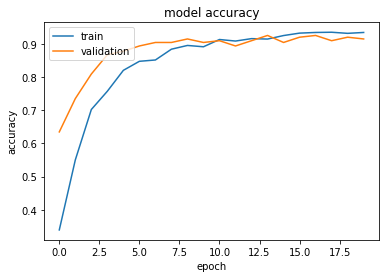

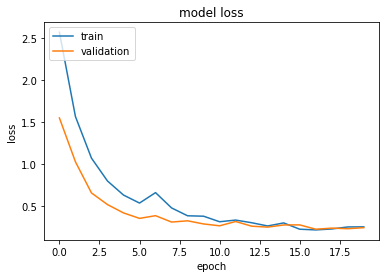

In [11]:
model_1.evaluate(X_val, y_val)
plot_performance_curves(history_1)

In [12]:
predictions = model_1.predict(X_test)
prediction_classes = model_1.predict_classes(X_test)
prediction_classes

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([5, 9, 4, 1, 4, 5, 9, 3, 3, 7, 7, 0, 7, 8, 0, 7, 7, 3, 5, 3, 3, 3,
       9, 3, 3, 5, 7, 7, 0, 4, 4, 0, 3, 1, 6, 3, 1, 3, 9, 9, 0, 1, 5, 9,
       4, 7, 3, 3, 3, 6, 9, 6, 0, 0, 8, 3, 5, 3, 3, 3, 3, 7, 8, 7, 0, 0,
       4, 6, 3, 3, 3, 4, 3, 5, 1, 4, 9, 7, 4, 5, 0, 1, 6, 9, 7, 3, 3, 3,
       1, 6, 0, 8, 0, 8, 7, 7, 3, 3, 3, 3, 3, 3, 7, 3, 7, 3, 3, 4, 1, 3,
       3, 3, 7, 7, 1, 9, 9, 4, 5, 1, 5, 9, 3, 4, 3, 3, 8, 6, 0, 3, 8, 7,
       3, 3, 3, 3, 7, 3, 5, 4, 1, 1, 4, 8, 7, 3, 3, 3, 1, 5, 0, 9, 5, 3,
       3, 9, 3, 9, 4, 0, 3, 3, 3, 3, 3, 7, 7, 3, 5, 0, 4, 0, 8, 8, 6, 3,
       3, 3, 6, 5, 5, 1, 0, 7, 3, 1, 0, 1, 3, 3, 9, 6, 1, 4, 8, 8, 4, 5,
       3, 3, 7, 5, 4, 1, 6, 6, 9, 9, 6, 3, 3, 9, 5, 9, 1, 7, 0, 5, 1, 1,
       9, 3, 3, 3, 6, 4, 8, 5, 8, 9, 7, 3, 3, 7, 5, 8, 6, 8, 3, 3, 6, 9,
       6, 9, 4, 5, 0, 7, 9, 3, 9, 3, 3, 8, 0, 5, 8, 7, 3, 3, 3, 3, 7, 3,
       3, 3, 5, 4, 5, 8, 6, 9, 3, 3, 3, 0, 9, 0, 9, 1, 1, 5, 1, 7, 3, 9,
       3, 8, 7, 3, 3, 0, 3, 3, 0, 3, 5, 3, 3, 3, 8,

In [13]:
pd.DataFrame(prediction_classes).to_csv("submission.csv")

# Train Model 2

In [14]:
model_2 = get_model_2(X_train)
model_2.summary()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


model_2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history_2 = model_2.fit(X_train, y_train, batch_size=64, epochs=200,
          verbose=2, validation_data=(X_val, y_val), callbacks=callback)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1024, 73, 32)      160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1023, 72, 48)      6192      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1022, 71, 120)     23160     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 511, 35, 120)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 511, 35, 120)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2146200)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

6/6 [==============================] - 1s 95ms/step - loss: 0.3816 - accuracy: 0.9312


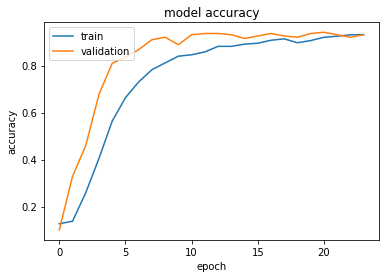

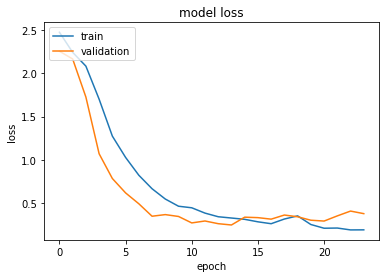

In [15]:
model_2.evaluate(X_val, y_val)
plot_performance_curves(history_2)

In [16]:
predictions = model_2.predict(X_test)
prediction_classes = model_2.predict_classes(X_test)
prediction_classes

array([5, 9, 4, 1, 4, 5, 9, 3, 3, 7, 7, 0, 9, 8, 0, 7, 7, 3, 5, 3, 3, 3,
       9, 3, 3, 5, 7, 7, 0, 4, 4, 0, 3, 1, 6, 3, 1, 3, 9, 9, 0, 1, 5, 9,
       4, 7, 3, 3, 3, 6, 9, 6, 0, 0, 8, 3, 5, 3, 3, 3, 3, 7, 8, 7, 0, 0,
       4, 6, 3, 3, 3, 4, 3, 5, 1, 4, 9, 7, 4, 5, 0, 1, 6, 9, 7, 3, 3, 3,
       1, 6, 0, 8, 0, 8, 7, 7, 3, 3, 3, 6, 3, 3, 7, 3, 7, 3, 3, 4, 1, 3,
       3, 3, 7, 7, 1, 9, 9, 4, 5, 1, 5, 9, 3, 4, 3, 3, 6, 3, 0, 3, 8, 7,
       3, 3, 3, 3, 7, 3, 5, 4, 4, 1, 4, 8, 7, 3, 3, 3, 1, 5, 0, 9, 5, 3,
       3, 9, 3, 9, 4, 0, 3, 3, 3, 3, 3, 7, 7, 3, 5, 0, 4, 0, 8, 8, 6, 3,
       3, 3, 6, 5, 5, 1, 0, 7, 7, 1, 0, 1, 3, 3, 9, 6, 1, 4, 8, 8, 4, 5,
       3, 3, 7, 5, 4, 1, 6, 6, 9, 9, 6, 3, 3, 9, 5, 9, 1, 7, 0, 5, 1, 6,
       9, 3, 3, 3, 6, 4, 8, 5, 8, 7, 7, 3, 3, 7, 5, 8, 6, 8, 3, 3, 6, 9,
       6, 9, 4, 5, 0, 7, 9, 3, 9, 3, 3, 8, 0, 5, 8, 7, 3, 3, 3, 6, 7, 3,
       3, 3, 5, 4, 5, 8, 6, 9, 3, 3, 3, 6, 9, 0, 9, 1, 1, 5, 1, 7, 3, 9,
       3, 8, 7, 3, 8, 0, 3, 3, 0, 3, 5, 3, 3, 3, 8,

In [17]:
pd.DataFrame(prediction_classes).to_csv("submission_2.csv")

# Train Model 3

In [18]:
model_3 = get_model_3(X_train)
model_3.summary()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


model_3.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history_3 = model_3.fit(X_train, y_train, batch_size=64, epochs=200,
          verbose=2, validation_data=(X_val, y_val), callbacks=callback)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 513, 37, 128)      1280      
_________________________________________________________________
batch_normalization (BatchNo (None, 513, 37, 128)      512       
_________________________________________________________________
dropout_5 (Dropout)          (None, 513, 37, 128)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 257, 19, 64)       32832     
_________________________________________________________________
batch_normalization_1 (Batch (None, 257, 19, 64)       256       
_________________________________________________________________
dropout_6 (Dropout)          (None, 257, 19, 64)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 129, 10, 64)      

6/6 [==============================] - 0s 39ms/step - loss: 2.9599 - accuracy: 0.1270


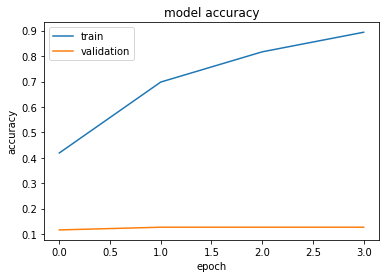

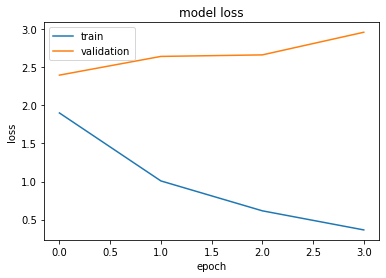

In [19]:
model_3.evaluate(X_val, y_val)
plot_performance_curves(history_3)

In [20]:
predictions = model_3.predict(X_test)
prediction_classes = model_3.predict_classes(X_test)
prediction_classes

array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,

In [21]:
pd.DataFrame(prediction_classes).to_csv("submission_3.csv")